# XGBoost para classificação da direção de criptos

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime

In [339]:
# Leitura dos dados
SYMBOL = 'XTZUSDT'
PERIOD = '1h'
df = pd.read_csv(f'..//..//data//fechamentos//{SYMBOL}_{PERIOD}_data.csv')
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)
    
# Drop de colunas desnecessárias, quando o modelo é puxado pelo novo código
try:
    df.drop(columns=['close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], inplace=True)
except:
    pass

In [340]:
# Construção das features
def create_features(df_input): # Renomeei para df_input para evitar conflito
    df_temp = df_input.copy()
    epsilon = 1e-10

    # Retorno e Volatilidade
    df_temp['return'] = df_temp['close'].pct_change()
    df_temp['return_skew_30'] = df_temp['return'].rolling(window=30).skew()
    df_temp['return_kurt_30'] = df_temp['return'].rolling(window=30).kurt()
    df_temp['volatility_10'] = df_temp['return'].rolling(window=10).std()
    df_temp['volatility_30'] = df_temp['return'].rolling(window=30).std()
    df_temp['volatility_200'] = df_temp['return'].rolling(window=200).std()
    df_temp['realized_vol_10'] = ((np.log(df_temp['high']) - np.log(df_temp['low']))**2 / 2 - \
                                (2 * np.log(2) - 1) * (np.log(df_temp['close']) - np.log(df_temp['open']))**2)\
                                .rolling(window=10).mean().apply(np.sqrt)
    df_temp['realized_vol_30'] = ((np.log(df_temp['high']) - np.log(df_temp['low']))**2 / 2 - \
                                (2 * np.log(2) - 1) * (np.log(df_temp['close']) - np.log(df_temp['open']))**2)\
                                .rolling(window=30).mean().apply(np.sqrt)
    df_temp['realized_vol_200'] = ((np.log(df_temp['high']) - np.log(df_temp['low']))**2 / 2 - \
                                (2 * np.log(2) - 1) * (np.log(df_temp['close']) - np.log(df_temp['open']))**2)\
                                .rolling(window=200).mean().apply(np.sqrt)

    # Volume
    def chaikin_money_flow(df, period=20):
        mfv = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'] + epsilon) * df['volume']
        cmf = mfv.rolling(window=period).sum() / df['volume'].rolling(window=period).sum()
        return cmf
    df_temp['cmf_10'] = chaikin_money_flow(df_temp, period=10)
    df_temp['cmf_30'] = chaikin_money_flow(df_temp, period=30)
    df_temp['cmf_200'] = chaikin_money_flow(df_temp, period=200)

    df_temp['volume_10_normalizado'] = df_temp['volume'] / (df_temp['volume'].rolling(window=10).mean() + epsilon)
    df_temp['volume_30_normalizado'] = df_temp['volume'] / (df_temp['volume'].rolling(window=30).mean() + epsilon)
    df_temp['volume_200_normalizado'] = df_temp['volume'] / (df_temp['volume'].rolling(window=200).mean() + epsilon)

    # Osciladores
    def williams_r(high, low, close, period=14):
        highest_high = high.rolling(window=period).max()
        lowest_low = low.rolling(window=period).min()
        return ((highest_high - close) / (highest_high - lowest_low + epsilon)) * -100
    df_temp['williams_r_10'] = williams_r(df_temp['high'], df_temp['low'], df_temp['close'], period=10)
    df_temp['williams_r_10_slope'] = df_temp['williams_r_10'].diff().rolling(window=5).mean()
    df_temp['williams_r_30'] = williams_r(df_temp['high'], df_temp['low'], df_temp['close'], period=30)
    df_temp['williams_r_30_slope'] = df_temp['williams_r_30'].diff().rolling(window=5).mean()
    df_temp['williams_r_200'] = williams_r(df_temp['high'], df_temp['low'], df_temp['close'], period=200)
    df_temp['williams_r_200_slope'] = df_temp['williams_r_200'].diff().rolling(window=5).mean()

    # MACD
    ema_12 = df_temp['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df_temp['close'].ewm(span=26, adjust=False).mean()
    df_temp['macd'] = ema_12 - ema_26
    df_temp['macd_normalizado'] = df_temp['macd'] / df_temp['close']
    df_temp['macd_signal'] = df_temp['macd'].ewm(span=9, adjust=False).mean()
    df_temp['macd_hist'] = df_temp['macd'] - df_temp['macd_signal']
    df_temp['macd_slope'] = df_temp['macd'].diff().rolling(window=5).mean()

    # Bandas de Bollinger
    rolling_mean_20 = df_temp['close'].rolling(window=20).mean()
    rolling_std_20 = df_temp['close'].rolling(window=20).std()
    df_temp['bb_upper'] = rolling_mean_20 + (rolling_std_20 * 2)
    df_temp['bb_lower'] = rolling_mean_20 - (rolling_std_20 * 2)
    df_temp['bb_width'] = df_temp['bb_upper'] - df_temp['bb_lower']
    df_temp['bb_pos'] = (df_temp['close'] - df_temp['bb_lower']) / (df_temp['bb_width'] + epsilon)
    df_temp['bb_width_normalizada'] = (df_temp['bb_upper'] - df_temp['bb_lower']) / df_temp['close']

    # Volume
    price_direction = np.sign(df_temp['close'].diff()).fillna(0)
    df_temp['obv'] = (price_direction * df_temp['volume']).cumsum()
    df_temp['obv_slope'] = df_temp['obv'].diff().rolling(window=5).mean()
    df_temp['vol_osc'] = df_temp['volume'].rolling(5).mean() / (df_temp['volume'].rolling(20).mean() + epsilon)
    def calculate_ad(df):
        mfm = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'])
        mfm = mfm.fillna(0)
        mfv = mfm * df['volume']
        ad_line = mfv.cumsum()
        return ad_line
    df_temp['ad'] = calculate_ad(df_temp[['close', 'high', 'low', 'volume']])

    # Volatilidade (ATR)
    def atr(df_atr, window=14):
        tr_high_low = df_atr['high'] - df_atr['low']
        tr_high_prev_close = abs(df_atr['high'] - df_atr['close'].shift())
        tr_low_prev_close = abs(df_atr['low'] - df_atr['close'].shift())
        tr = pd.DataFrame({'hl': tr_high_low, 'hpc': tr_high_prev_close, 'lpc': tr_low_prev_close}).max(axis=1)
        return tr.rolling(window=window).mean()
    df_temp['atr_10'] = atr(df_temp, window=10)
    df_temp['atr_10_normalizado'] = df_temp['atr_10'] / df_temp['close']
    df_temp['atr_10_slope'] = df_temp['atr_10'].diff().rolling(window=5).mean()
    df_temp['atr_30'] = atr(df_temp, window=20)
    df_temp['atr_30_normalizado'] = df_temp['atr_30'] / df_temp['close']
    df_temp['atr_30_slope'] = df_temp['atr_30'].diff().rolling(window=5).mean()
    df_temp['atr_200'] = atr(df_temp, window=200)
    df_temp['atr_200_normalizado'] = df_temp['atr_200'] / df_temp['close']
    df_temp['atr_200_slope'] = df_temp['atr_200'].diff().rolling(window=5).mean()

    # ADX (Força da Tendência)
    def adx(df_adx, period=14):
        high = df_adx['high']
        low = df_adx['low']
        close = df_adx['close']

        up = high.diff()
        down = -low.diff()

        plus_dm = np.where((up > down) & (up > 0), up, 0)
        minus_dm = np.where((down > up) & (down > 0), down, 0)

        tr1 = high - low
        tr2 = abs(high - close.shift(1))
        tr3 = abs(low - close.shift(1))
        tr = pd.DataFrame({'tr1': tr1, 'tr2': tr2, 'tr3': tr3}).max(axis=1)

        atr_val = tr.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        plus_di = 100 * (pd.Series(plus_dm, index=df_adx.index).ewm(alpha=1/period, min_periods=period, adjust=False).mean() / (atr_val + epsilon))
        minus_di = 100 * (pd.Series(minus_dm, index=df_adx.index).ewm(alpha=1/period, min_periods=period, adjust=False).mean() / (atr_val + epsilon))

        dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di + epsilon))
        adx_val = dx.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        return adx_val, plus_di, minus_di
    df_temp['adx_10'], df_temp['pdi_10'], df_temp['ndi_10'] = adx(df_temp, period=10)
    df_temp['adx_30'], df_temp['pdi_30'], df_temp['ndi_30'] = adx(df_temp, period=30)
    df_temp['adx_10_slope'] = df_temp['adx_10'].diff().rolling(window=5).mean()
    df_temp['pdi_10_slope'] = df_temp['pdi_10'].diff().rolling(window=5).mean()
    df_temp['ndi_10_slope'] = df_temp['ndi_10'].diff().rolling(window=5).mean()
    df_temp['adx_30_slope'] = df_temp['adx_30'].diff().rolling(window=5).mean()
    df_temp['pdi_30_slope'] = df_temp['pdi_30'].diff().rolling(window=5).mean()
    df_temp['ndi_30_slope'] = df_temp['ndi_30'].diff().rolling(window=5).mean()

    # RSI (Índice de Força Relativa)
    def rsi(close, period=14):
        delta = close.diff()
        gain = delta.clip(lower=0).ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        loss = -delta.clip(upper=0).ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        rs = gain / (loss + epsilon)
        return 100 - (100 / (1 + rs))
    df_temp['rsi_10'] = rsi(df_temp['close'], period=10)
    df_temp['rsi_10_slope'] = df_temp['rsi_10'].diff().rolling(window=5).mean()
    df_temp['rsi_30'] = rsi(df_temp['close'], period=30)
    df_temp['rsi_30_slope'] = df_temp['rsi_30'].diff().rolling(window=5).mean()

    # Momentum
    def mom(close, period=10):
        return close.diff(period)
    df_temp['mom_10'] = mom(df_temp['close'], period=10)
    df_temp['mom_10_slope'] = df_temp['mom_10'].diff().rolling(window=5).mean()
    df_temp['mom_10_normalizado'] = df_temp['mom_10'] / df_temp['close']
    df_temp['mom_30'] = mom(df_temp['close'], period=30)
    df_temp['mom_30_slope'] = df_temp['mom_30'].diff().rolling(window=5).mean()
    df_temp['mom_30_normalizado'] = df_temp['mom_30'] / df_temp['close']
    df_temp['mom_200'] = mom(df_temp['close'], period=200)
    df_temp['mom_200_slope'] = df_temp['mom_200'].diff().rolling(window=5).mean()
    df_temp['mom_200_normalizado'] = df_temp['mom_200'] / df_temp['close']

    # Estocástico
    def stochastic_oscillator(high, low, close, period=14):
        lowest_low = low.rolling(window=period).min()
        highest_high = high.rolling(window=period).max()
        k = 100 * ((close - lowest_low) / (highest_high - lowest_low + epsilon))
        d = k.rolling(window=3).mean()
        return k, d
    df_temp['stoch_10'], df_temp['stoch_d_10'] = stochastic_oscillator(df_temp['high'], df_temp['low'], df_temp['close'], period=10)
    df_temp['stoch_10_slope'] = df_temp['stoch_10'].diff().rolling(window=5).mean()
    df_temp['stoch_d_10_slope'] = df_temp['stoch_d_10'].diff().rolling(window=5).mean()
    df_temp['stoch_30'], df_temp['stoch_d_30'] = stochastic_oscillator(df_temp['high'], df_temp['low'], df_temp['close'], period=30)
    df_temp['stoch_30_slope'] = df_temp['stoch_30'].diff().rolling(window=5).mean()
    df_temp['stoch_d_30_slope'] = df_temp['stoch_d_30'].diff().rolling(window=5).mean()
    df_temp['stoch_200'], df_temp['stoch_d_200'] = stochastic_oscillator(df_temp['high'], df_temp['low'], df_temp['close'], period=200)
    df_temp['stoch_200_slope'] = df_temp['stoch_200'].diff().rolling(window=5).mean()
    df_temp['stoch_d_200_slope'] = df_temp['stoch_d_200'].diff().rolling(window=5).mean()

    # Parabolic SAR
    def parabolic_sar(high, low, close, acceleration=0.02, maximum=0.2):
        length = len(close)
        if length < 2:
            return pd.Series([None] * length, index=close.index)
        sar = [None] * length
        is_long = close.iloc[1] > close.iloc[0]
        sar[1] = low.iloc[0] if is_long else high.iloc[0]
        ep = high.iloc[1] if is_long else low.iloc[1]
        af = acceleration

        for i in range(2, length):
            prev_sar = sar[i-1]
            if is_long:
                new_sar = prev_sar + af * (ep - prev_sar)
                if new_sar > low.iloc[i] or new_sar > low.iloc[i-1]:
                    is_long = False
                    af = acceleration
                    new_sar = ep
                    ep = low.iloc[i]
                else:
                    if high.iloc[i] > ep:
                        ep = high.iloc[i]
                        af = min(af + acceleration, maximum)
            else:
                new_sar = prev_sar + af * (ep - prev_sar)
                if new_sar < high.iloc[i] or new_sar < high.iloc[i-1]:
                    is_long = True
                    af = acceleration
                    new_sar = ep
                    ep = high.iloc[i]
                else:
                    if low.iloc[i] < ep:
                        ep = low.iloc[i]
                        af = min(af + acceleration, maximum)
            sar[i] = new_sar

        return pd.Series(sar, index=close.index)
    df_temp['sar'] = parabolic_sar(df_temp['high'], df_temp['low'], df_temp['close'])
    df_temp['sar_slope'] = df_temp['sar'].diff().rolling(window=5).mean()
    df_temp['sar_normalizado'] = df_temp['sar'] / df_temp['close']

    # EMA (Média Móvel Exponencial)
    df_temp['ema_10'] = df_temp['close'].ewm(span=10, adjust=False).mean()
    df_temp['ema_50'] = df_temp['close'].ewm(span=50, adjust=False).mean()
    df_temp['ema_200'] = df_temp['close'].ewm(span=200, adjust=False).mean()
    df_temp['ema_10_slope'] = df_temp['ema_10'].diff().rolling(window=5).mean()
    df_temp['ema_50_slope'] = df_temp['ema_50'].diff().rolling(window=5).mean()
    df_temp['ema_200_slope'] = df_temp['ema_200'].diff().rolling(window=5).mean()
    df_temp['ema_10_normalizada'] = df_temp['ema_10'] / df_temp['close']
    df_temp['ema_50_normalizada'] = df_temp['ema_50'] / df_temp['close']
    df_temp['ema_200_normalizada'] = df_temp['ema_200'] / df_temp['close']

    # Retorno Cumulativo
    df_temp['cum_return_10'] = df_temp['close'].rolling(10).apply(lambda x: (x.iloc[-1] / x.iloc[0]) - 1)
    df_temp['cum_return_30'] = df_temp['close'].rolling(30).apply(lambda x: (x.iloc[-1] / x.iloc[0]) - 1)
    df_temp['cum_return_200'] = df_temp['close'].rolling(200).apply(lambda x: (x.iloc[-1] / x.iloc[0]) - 1)

    # Lag Features
    lag_cols = df_temp.columns.tolist()
    for col in lag_cols:
        for lag in range(1, 4):
            df_temp[f'{col}_lag_{lag}'] = df_temp[col].shift(lag)

    df_temp.dropna(inplace=True)
    return df_temp

# Aplica a função de criação de features
df = create_features(df)

# --- DEFINIÇÃO DO TARGET ---
retorno_futuro = df['close'].shift(-1) / df['close'] - 1
limiar_lucro = 0.0

df['target'] = np.where(retorno_futuro > limiar_lucro, 1, 0) # 1 para retorno acima do limiar, 0 para abaixo

print(df['target'].value_counts(normalize=True))
print(df['target'].value_counts())

# Divisão dos dados entre até 2025 e a partir de 2025
df_in_sample = df[df.index < '2025-01-01']
df_out_of_sample = df[df.index >= '2025-01-01']

C:\Users\david\AppData\Local\Temp\ipykernel_27500\2243913588.py:233: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[f'{col}_lag_{lag}'] = df_temp[col].shift(lag)
C:\Users\david\AppData\Local\Temp\ipykernel_27500\2243913588.py:233: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[f'{col}_lag_{lag}'] = df_temp[col].shift(lag)
C:\Users\david\AppData\Local\Temp\ipykernel_27500\2243913588.py:233: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

target
0    0.515039
1    0.484961
Name: proportion, dtype: float64
target
0    26148
1    24621
Name: count, dtype: int64


C:\Users\david\AppData\Local\Temp\ipykernel_27500\2243913588.py:245: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = np.where(retorno_futuro > limiar_lucro, 1, 0) # 1 para retorno acima do limiar, 0 para abaixo


--- INICIANDO VALIDAÇÃO E SIMULAÇÃO ENCADEADA COM 6 FOLDS ---

--- Processando Fold 1/6 ---
Quantidade dos dados: 5257 para treino e 1315 para calibração
Benchmark 'Buy & Hold' total iniciará em 2020-07-03 com preço 2.31
MAPIE - Cobertura no fold: 93.44% | Tamanho médio do conjunto: 1.85
Saldo inicial do Fold: 1000.00 | Saldo Final do Fold: 1998.04 | Trades: 114

--- Processando Fold 2/6 ---
Quantidade dos dados: 10510 para treino e 2628 para calibração
MAPIE - Cobertura no fold: 93.16% | Tamanho médio do conjunto: 1.85
Saldo inicial do Fold: 1998.04 | Saldo Final do Fold: 1950.29 | Trades: 78

--- Processando Fold 3/6 ---
Quantidade dos dados: 15763 para treino e 3941 para calibração
MAPIE - Cobertura no fold: 95.19% | Tamanho médio do conjunto: 1.89
Saldo inicial do Fold: 1950.29 | Saldo Final do Fold: 1758.60 | Trades: 46

--- Processando Fold 4/6 ---
Quantidade dos dados: 21016 para treino e 5254 para calibração
MAPIE - Cobertura no fold: 94.96% | Tamanho médio do conjunto: 1.88
Sa

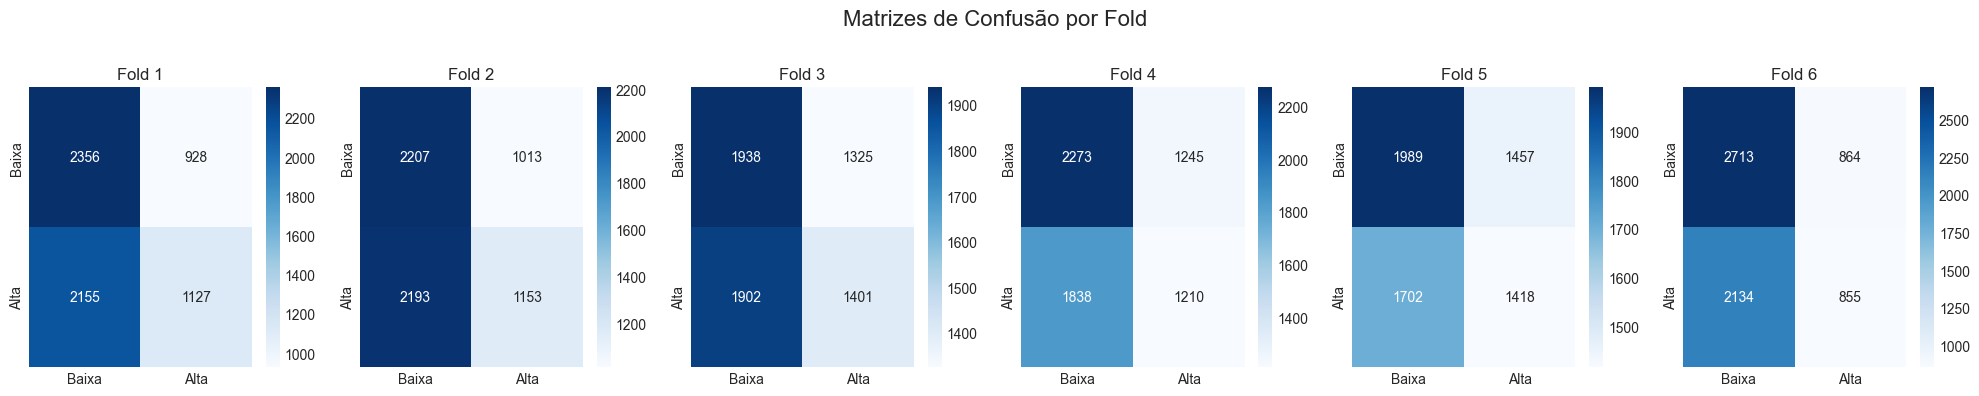


-----------------------------------
| Resumo das Métricas por Fold      |
-----------------------------------


,AUC,Acurácia,Precisão,Recall,F1 Score
Fold,,,,,
1,0.551173,0.530460,0.548418,0.343388,0.422335
2,0.528620,0.511727,0.532318,0.344591,0.418360
3,0.522713,0.508529,0.513940,0.424160,0.464754
4,0.528348,0.530460,0.492872,0.396982,0.439760
5,0.530349,0.518885,0.493217,0.454487,0.473061
6,0.539701,0.543405,0.497382,0.286049,0.363212


Média do AUC: 0.5335
Média do Recall: 0.3749


------------------------------------------------------------
| Resumo da Performance da Simulação por Fold de Teste      |
------------------------------------------------------------
 Fold Período Início Período Fim  Saldo Inicial  Saldo Final  Retorno Estratégia (%)  Retorno Buy & Hold (%)  Retorno Líquido (%)  Nº Trades
    1     2020-07-03  2021-04-03    1000.000000  1998.039544               99.803954              127.994983           -28.191029        114
    2     2021-04-03  2022-01-02    1998.039544  1950.285877               -2.390026              -11.047291             8.657265         78
    3     2022-01-02  2022-10-03    1950.285877  1758.595979               -9.828810              -70.462785            60.633975         46
    4     2022-10-03  2023-07-03    1758.595979  1978.887126               12.526535              -39.198856            51.725391         44
    5     2023-07-03  2024-04-02    1978.887126  2104.374252    

In [341]:
def simulate_trading(test_df_fold: pd.DataFrame,
                                initial_balance_fold: float,
                                fee: float = 0.001,
                                stop_loss: float = None,
                                take_profit: float = None,
                                trailing_stop: float = 0.02,
                                sma_window: int = 100) -> tuple[list, float]:
    """
    Simula uma estratégia de trading usando os conjuntos de previsão do MAPIE.
    """
    df_sim = test_df_fold.copy()

    balance = initial_balance_fold
    position = 0.0
    entry_price = 0.0
    trades = []

    # Variável para o trailing stop dinâmico
    trailing_stop_price = None

    # Calculo da média simples
    df_sim['sma_long'] = df_sim['close'].rolling(window=sma_window).mean()
    df_sim['sma_short'] = df_sim['close'].rolling(window=int(sma_window/5)).mean()

    # Simulação de passos no tempo
    for i in range(1, len(df_sim)):
        current_price = df_sim['close'].iloc[i]
        current_time = df_sim.index[i]

        # O sinal de trading é baseado na previsão do candle anterior, já que a previsão é feita no posterior
        prediction_set_t_minus_1 = df_sim['prediction_set'].iloc[i-1]

        # Verifica se já existe posição antes
        if position > 0:
            # 1. Stop-Loss
            if stop_loss is not None and current_price <= entry_price * (1 - stop_loss):
                balance = position * current_price * (1 - fee)
                trades.append(('Stop-Loss', current_time, current_price, balance, f'SL {stop_loss*100:.1f}% hit'))
                position, entry_price, trailing_stop_price = 0.0, 0.0, None
                continue

            # 2. Take-Profit
            if take_profit is not None and current_price >= entry_price * (1 + take_profit):
                balance = position * current_price * (1 - fee)
                trades.append(('Take-Profit', current_time, current_price, balance, f'TP {take_profit*100:.1f}% hit'))
                position, entry_price, trailing_stop_price = 0.0, 0.0, None
                continue

            # 3. Trailing Stop
            if trailing_stop is not None:
                # Compara o maior preço anterior e o atual para definir o novo stop price
                new_stop_price = current_price * (1 - trailing_stop)
                if trailing_stop_price is None:
                    trailing_stop_price = entry_price * (1 - trailing_stop)
                else:
                    trailing_stop_price = max(trailing_stop_price, new_stop_price)

                # Verifica se o trailing stop foi atingido
                if current_price <= trailing_stop_price:
                    balance = position * current_price * (1 - fee)
                    trades.append(('Trailing-Stop', current_time, current_price, balance, f'Trailing stop {trailing_stop*100:.1f}% hit'))
                    position, entry_price, trailing_stop_price = 0.0, 0.0, None
                    continue

        # Condições de entrada e saída
        is_uptrend = current_price > df_sim['sma_long'].iloc[i]
        is_downtrend = current_price < df_sim['sma_short'].iloc[i]

        # Compra quando o modelo está confiante na ALTA ([False, True]), não tem posição e o valor é maior que a média longa
        if np.array_equal(prediction_set_t_minus_1, [False, True]) and position == 0 and is_uptrend:
            amount_to_spend = balance * (1 - fee)
            qty = amount_to_spend / current_price
            position = qty
            entry_price = current_price
            trades.append(('Buy', current_time, current_price, balance, 'Sinal: Compra'))

        # Vende quando o modelo está confiante na BAIXA ([True, False]), não tem posição e o valor é menor que média curta
        elif np.array_equal(prediction_set_t_minus_1, [True, False]) and position > 0 and is_downtrend:
            balance = position * current_price * (1 - fee)
            trades.append(('Sell', current_time, current_price, balance, 'Sinal: Venda'))
            position, entry_price, trailing_stop_price = 0.0, 0.0, None

        # Anexa em trades a "ordem" hold, para acompanhar a variação da posição aberta
        elif position > 0:
            balance = position * current_price * (1 - fee)
            trades.append(('Hold', current_time, current_price, balance, 'Hold'))

    # Fecha as posições no fim da simulação
    if position > 0:
        last_price = df_sim['close'].iloc[-1]
        balance = position * last_price * (1 - fee)
        trades.append(('Liquidate_Final_Fold', df_sim.index[-1], last_price, balance, 'Fim do período de teste'))
        position = 0.0

    return trades, balance

# Configurações da Simulação
initial_balance = 1000.0
classification_threshold = 0.5

# Variáveis para armazenar resultados
results_list = []
full_simulation_trades = []
current_global_balance = initial_balance
fold_performance_list = []
overall_benchmark_start_price = None

# Validação cruzada com TimeSeriesSplit
n_splits = 6
tsv = TimeSeriesSplit(n_splits=n_splits)
X = df_in_sample.drop(columns=['target'])
y = df_in_sample['target']

fig, axes = plt.subplots(1, n_splits, figsize=(20, 4))
fig.suptitle('Matrizes de Confusão por Fold', fontsize=16)

print(f"--- INICIANDO VALIDAÇÃO E SIMULAÇÃO ENCADEADA COM {n_splits} FOLDS ---")

for fold, (train_index, test_index) in enumerate(tsv.split(X)):
    print(f"\n--- Processando Fold {fold + 1}/{n_splits} ---")
    X_train_full, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_full, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train, X_calib, y_train, y_calib = train_test_split(
        X_train_full, y_train_full, test_size=0.2, shuffle=False
    )

    print(f"Quantidade dos dados: {X_train.shape[0]} para treino e {X_calib.shape[0]} para calibração")

    # Captura o preço de início do benchmark na primeira iteração
    if fold == 0:
        first_test_period_start_index = X_test.index[0]
        overall_benchmark_start_price = df_in_sample.loc[first_test_period_start_index, 'close']
        print(f"Benchmark 'Buy & Hold' total iniciará em {first_test_period_start_index.date()} com preço {overall_benchmark_start_price:.2f}")

    # Construção do modelo
    model = xgb.XGBClassifier(
        n_estimators=1000, objective='binary:logistic', learning_rate=0.01,
        max_depth=5, scale_pos_weight=max(y_train.value_counts()[0], y_train.value_counts()[1]) / min(y_train.value_counts()[1], y_train.value_counts()[0]),
        subsample=0.8, colsample_bytree=0.9, gamma=0.2, reg_lambda=1.2, reg_alpha=0.2,
        early_stopping_rounds=50, random_state=1, n_jobs=-1
    )

    # Treinamento do modelo
    model.fit(X_train, y_train, eval_set=[(X_calib, y_calib)], verbose=0)

    # Predição dos dados
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > classification_threshold).astype(int)

    # Armazenamento dos resultados do fold
    fold_results = {
        'Fold': fold + 1, 'AUC': roc_auc_score(y_test, y_proba),
        'Acurácia': accuracy_score(y_test, y_pred), 'Precisão': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0), 'F1 Score': f1_score(y_test, y_pred, zero_division=0)
    }
    results_list.append(fold_results)

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[fold], xticklabels=['Baixa', 'Alta'], yticklabels=['Baixa', 'Alta'])
    axes[fold].set_title(f'Fold {fold + 1}')

    # Ajuste do modelo MAPIE
    mapie_model = MapieClassifier(estimator=model, method="lac", cv="prefit")
    mapie_model.fit(X_calib, y_calib)

    alpha = 0.05  # Nível de significância
    y_pred, y_set = mapie_model.predict(X_test, alpha=alpha)
    y_set = np.squeeze(y_set)

    # Calcula e exibe métricas de incerteza para o fold
    coverage = classification_coverage_score(y_test, y_set)
    set_size = classification_mean_width_score(y_set)
    print(f"MAPIE - Cobertura no fold: {coverage:.2%} | Tamanho médio do conjunto: {set_size:.2f}")

    # Preparação dos dados para simulação
    test_df_for_sim = df_in_sample.loc[X_test.index].copy()
    test_df_for_sim['target'] = y_test
    test_df_for_sim['prediction_set'] = list(y_set)

    fold_initial_balance = current_global_balance

    # Simulação Out-of-Sample para confirmação da ausência de overfitting
    trades_fold, final_balance_fold = simulate_trading(
        test_df_for_sim,
        initial_balance_fold=fold_initial_balance,
        trailing_stop=0.1,
        take_profit=0.2,
        stop_loss=0.1,
        sma_window=100
    )

    print(f"Saldo inicial do Fold: {fold_initial_balance:.2f} | Saldo Final do Fold: {final_balance_fold:.2f} | Trades: {len([trade for trade in trades_fold if trade[0] != 'Hold'])}")

    # Cálculo dos Retornos
    strategy_return_fold = ((final_balance_fold - fold_initial_balance) / fold_initial_balance) * 100 if fold_initial_balance > 0 else 0
    buy_and_hold_start_price = test_df_for_sim['close'].iloc[0]
    buy_and_hold_end_price = test_df_for_sim['close'].iloc[-1]
    buy_and_hold_return_fold = ((buy_and_hold_end_price - buy_and_hold_start_price) / buy_and_hold_start_price) * 100

    # Armazenamento dos resultados do fold
    fold_performance_list.append({
        "Fold": fold + 1, "Período Início": X_test.index[0].date(),
        "Período Fim": X_test.index[-1].date(), "Saldo Inicial": fold_initial_balance,
        "Saldo Final": final_balance_fold, "Retorno Estratégia (%)": strategy_return_fold,
        "Retorno Buy & Hold (%)": buy_and_hold_return_fold, "Retorno Líquido (%)": strategy_return_fold - buy_and_hold_return_fold,
        "Nº Trades": len([trade for trade in trades_fold if trade[0] != 'Hold'])
    })

    current_global_balance = final_balance_fold
    full_simulation_trades.extend(trades_fold)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- APRESENTAÇÃO DOS RESULTADOS ---

# 1. Métricas de Classificação por Fold
results_df = pd.DataFrame(results_list)
print("\n" + "-"*35)
print("| Resumo das Métricas por Fold      |")
print("-"*(35))
display(results_df.set_index('Fold'))
print(f"Média do AUC: {results_df['AUC'].mean():.4f}")
print(f"Média do Recall: {results_df['Recall'].mean():.4f}")
results_df.to_csv(f'..//..//figures//ml//results_classification_{SYMBOL}.csv', index=False)

# 2. Performance da Estratégia por Fold
print("\n\n" + "-"*60)
print("| Resumo da Performance da Simulação por Fold de Teste      |")
print("-"*(60))
performance_by_fold_df = pd.DataFrame(fold_performance_list)
print(performance_by_fold_df.to_string(index=False))
performance_by_fold_df.to_csv(f'..//..//figures//ml//results_performance_{SYMBOL}.csv', index=False)

# 3. Resumo Final da Simulação Encadeada
print("\n\n--- Resumo Final da Simulação (Total) ---")

total_return = ((current_global_balance - initial_balance) / initial_balance) * 100
overall_benchmark_end_price = df_in_sample['close'].iloc[-1]
total_return_natural = ((overall_benchmark_end_price - overall_benchmark_start_price) / overall_benchmark_start_price) * 100

print(f"Saldo Inicial Total: {initial_balance:.2f} USDT")
print(f"Saldo Final Total: {current_global_balance:.2f} USDT")
print(f"Retorno Total no Período (Estratégia): {total_return:.2f}%")
print(f"Retorno Total no Período (Buy & Hold): {total_return_natural:.2f}%")
print(f"Retorno Total Líquido (Alpha): {total_return - total_return_natural:.2f}%")
print(f"Total de Transações: {len([trade for trade in full_simulation_trades if trade[0] != 'Hold'])}")
print("--- Fim da Simulação ---")

In [342]:
# --- VALIDAÇÃO FINAL OUT-OF-SAMPLE (OOS) ---
# Nessa etapa não ocorre o retreinamento do modelo

# 1. Prepara os dados de features (X) para o período OOS
X_out_of_sample = df_out_of_sample[X.columns]

# 2. Gera os conjuntos de previsão MAPIE para os dados OOS
y_pred_oos, y_set_oos = mapie_model.predict(X_out_of_sample, alpha=0.1)
y_set_oos = np.squeeze(y_set_oos)

# 3. Calcula e exibe métricas de incerteza para o período OOS
y_out_of_sample = df_out_of_sample['target']
coverage_oos = classification_coverage_score(y_out_of_sample, y_set_oos)
set_size_oos = classification_mean_width_score(y_set_oos)
print(f"MAPIE OOS - Cobertura: {coverage_oos:.2%} | Tamanho médio do conjunto: {set_size_oos:.2f}")

# 4. Prepara o DataFrame para a simulação
test_df_for_sim_oos = df_out_of_sample.copy()
test_df_for_sim_oos['prediction_set'] = list(y_set_oos)

# 5. Executa a simulação de trading
initial_balance_oos = current_global_balance
print(f"Iniciando simulação OOS com saldo de {initial_balance_oos:.2f} USDT")

trades_oos, final_balance_oos = simulate_trading(
    test_df_fold=test_df_for_sim_oos,
    initial_balance_fold=initial_balance_oos,
    trailing_stop=0.1,
    take_profit=0.2,
    stop_loss=0.1,
    sma_window=100
)

# 6. Apresenta os resultados da simulação Out-of-Sample
print("\n--- Resumo do Período OOS ---")
print(f"Período OOS: de {df_out_of_sample.index[0].date()} a {df_out_of_sample.index[-1].date()}")
print(f"Saldo inicial OOS: {initial_balance_oos:.2f} USDT")
print(f"Saldo Final OOS: {final_balance_oos:.2f} USDT")
print(f"Total de Trades no período: {len([trade for trade in trades_oos if trade[0] != 'Hold'])}")

# 7. Calcula e exibe os retornos
strategy_return_oos = ((final_balance_oos - initial_balance_oos) / initial_balance_oos) * 100 if initial_balance_oos > 0 else 0
buy_and_hold_return_oos = ((df_out_of_sample['close'].iloc[-1] - df_out_of_sample['close'].iloc[0]) / df_out_of_sample['close'].iloc[0]) * 100

print(f"\nLucro/Prejuízo no período OOS: {final_balance_oos - initial_balance_oos:.2f} USDT")
print(f"Retorno da Estratégia (OOS): {strategy_return_oos:.2f}%")
print(f"Retorno Buy & Hold (OOS): {buy_and_hold_return_oos:.2f}%")
print(f"Retorno Líquido vs Buy & Hold (Alpha OOS): {strategy_return_oos - buy_and_hold_return_oos:.2f}%")
print("="*60)

MAPIE OOS - Cobertura: 94.06% | Tamanho médio do conjunto: 1.87
Iniciando simulação OOS com saldo de 2410.65 USDT

--- Resumo do Período OOS ---
Período OOS: de 2025-01-01 a 2025-07-20
Saldo inicial OOS: 2410.65 USDT
Saldo Final OOS: 2155.79 USDT
Total de Trades no período: 30

Lucro/Prejuízo no período OOS: -254.86 USDT
Retorno da Estratégia (OOS): -10.57%
Retorno Buy & Hold (OOS): -22.65%
Retorno Líquido vs Buy & Hold (Alpha OOS): 12.08%


<Axes: title={'center': 'Importância das Features por Frequência - XTZUSDT'}, xlabel='Importance score', ylabel='Features'>

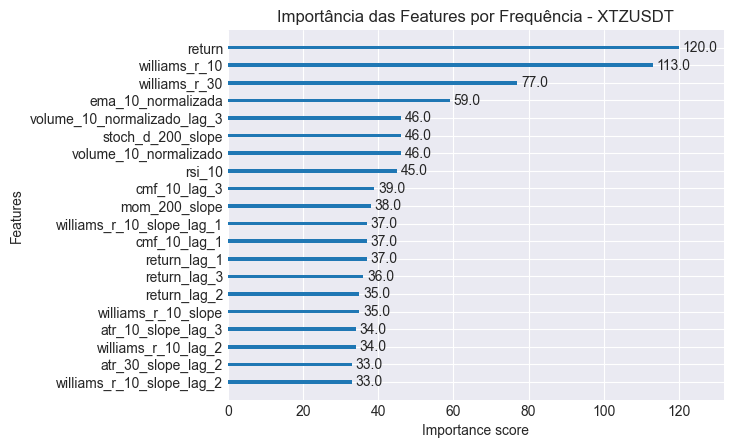

In [343]:
xgb.plot_importance(model, max_num_features=20, importance_type='weight', title=f'Importância das Features por Frequência - {SYMBOL}')

<Axes: title={'center': 'Importância das Features por Ganho - XTZUSDT'}, xlabel='Importance score', ylabel='Features'>

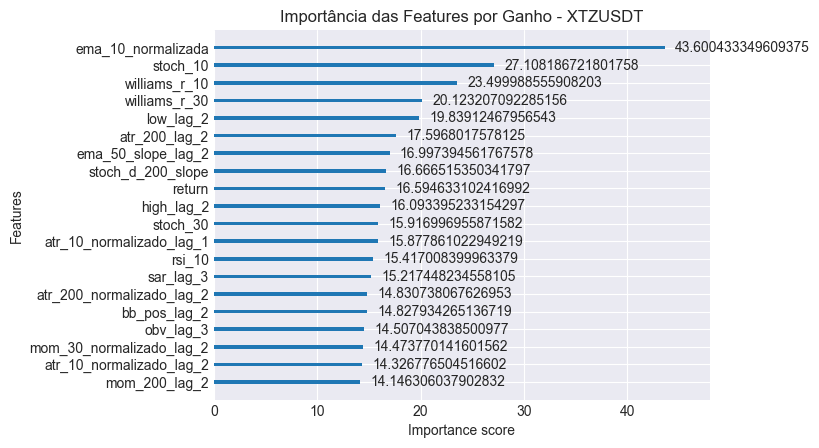

In [344]:
xgb.plot_importance(model, max_num_features=20, importance_type='gain', title=f'Importância das Features por Ganho - {SYMBOL}')

C:\Users\david\AppData\Local\Temp\ipykernel_27500\1901744893.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trades['Saldo_norm'].fillna(1, inplace=True)
C:\Users\david\AppData\Local\Temp\ipykernel_27500\1901744893.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

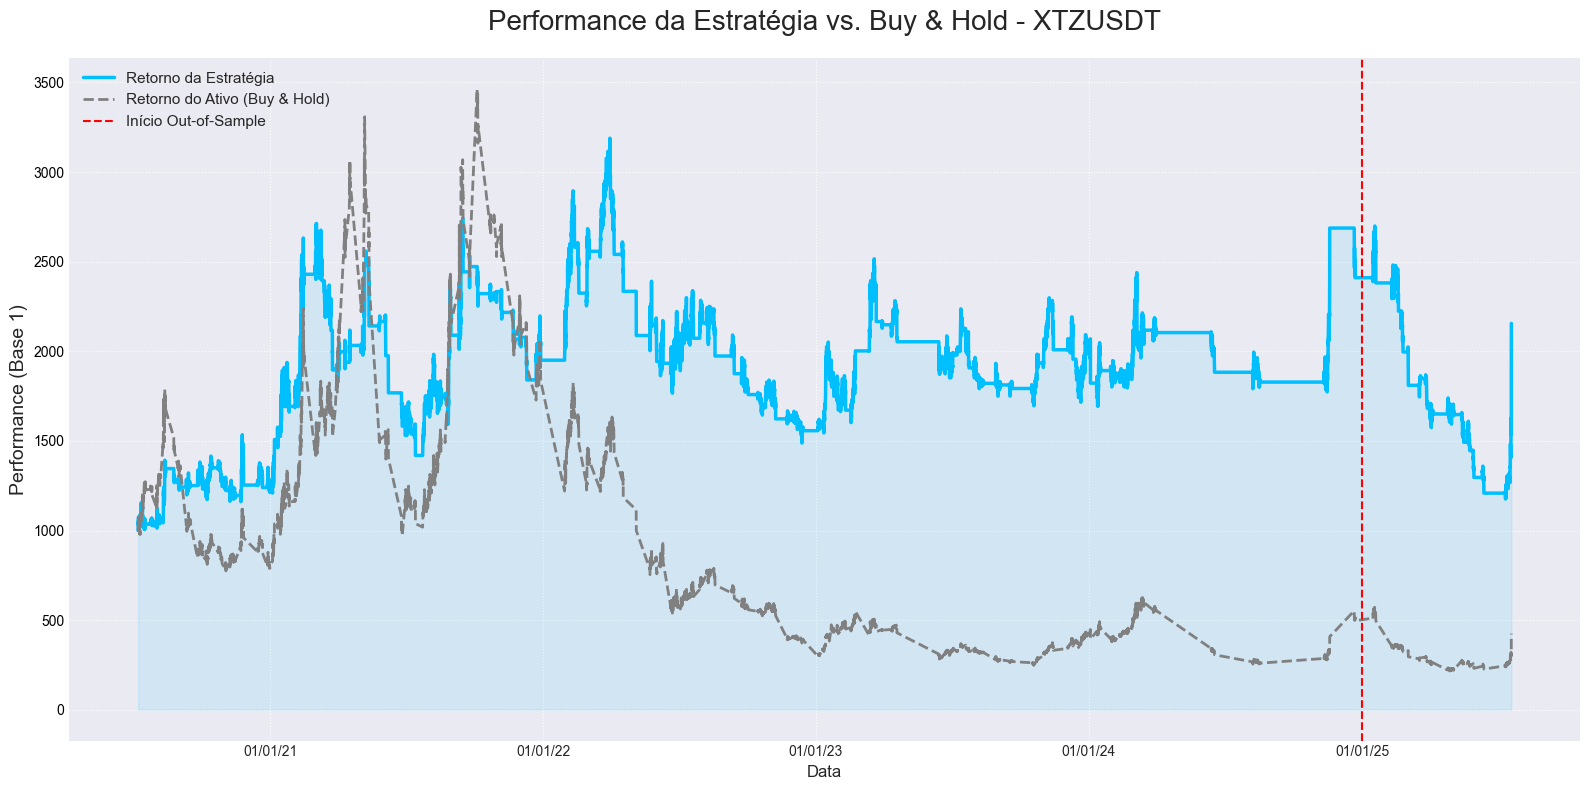

In [345]:
# --- ORGANIZAÇÃO DAS TRADES ---
# 1. Junta todas as trades
full_simulation_trades.extend(trades_oos)
trades = pd.DataFrame(full_simulation_trades, columns=['Ordem', 'Timestamp', 'Valor', 'Saldo', 'Sinal'])

# 2. Converte a coluna 'Timestamp' para o tipo datetime
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'])
trades.sort_values(by='Timestamp', inplace=True)
trades.drop_duplicates(inplace=True)

# 3. Normalizar os valores para Comparação
trades['Saldo_norm'] = (trades['Saldo'].pct_change() + 1).cumprod()
trades['Valor_norm'] = (trades['Valor'].pct_change() + 1).cumprod()

trades['Saldo_norm'].fillna(1, inplace=True)
trades['Valor_norm'].fillna(1, inplace=True)

trades['Saldo_norm'] = trades['Saldo_norm'] * 1000
trades['Valor_norm'] = trades['Valor_norm'] * 1000

# --- CONSTRUÇÃO DO GRÁFICO ---
# 1. Estilo e figura
fig, ax1 = plt.subplots(figsize=(16, 8))

# 2. Plota a curva de Saldo Normalizado
ax1.plot(trades['Timestamp'], trades['Saldo_norm'], color='deepskyblue', linewidth=2.5, label='Retorno da Estratégia', zorder=2)
ax1.fill_between(trades['Timestamp'], trades['Saldo_norm'], 1, alpha=0.1, color='deepskyblue', where=trades['Saldo_norm'] >= 1)
ax1.fill_between(trades['Timestamp'], trades['Saldo_norm'], 1, alpha=0.1, color='crimson', where=trades['Saldo_norm'] < 1)

# 3. Plota a curva do Ativo Normalizado (Benchmark)
ax1.plot(trades['Timestamp'], trades['Valor_norm'], color='gray', linestyle='--', linewidth=2, label='Retorno do Ativo (Buy & Hold)')

# 4. Adiciona marcadores de Compra e Venda
# buy_trades = trades[trades['Ordem'].str.contains('Buy')]
# sell_trades = trades[trades['Ordem'].str.contains('Stop|Sell|Profit|Liquidate')]
# ax1.scatter(buy_trades['Timestamp'], buy_trades['Saldo_norm'], color='lime', marker='^', s=120, label='Compra', zorder=3, ec='black')
# ax1.scatter(sell_trades['Timestamp'], sell_trades['Saldo_norm'], color='red', marker='v', s=120, label='Venda/Stop', zorder=3, ec='black')

# 5. Configura o eixo Y unificado
data_separacao = datetime.datetime(2025, 1, 1)
ax1.axvline(x=data_separacao, color='red', linestyle='--', linewidth=1.5, label='Início Out-of-Sample')
ax1.set_ylabel('Performance (Base 1)', fontsize=14)
ax1.tick_params(axis='y', labelcolor='black')

# 6. Configura Título e Eixo X
ax1.set_xlabel('Data', fontsize=12)
ax1.set_title(f'Performance da Estratégia vs. Buy & Hold - {SYMBOL}', fontsize=20, pad=20)

# 7. Formata as datas e a legenda
date_format = mdates.DateFormatter('%d/%m/%y')
ax1.xaxis.set_major_formatter(date_format)
ax1.legend(loc='upper left', fontsize=11)

# 8. Adiciona grid e ajustar layout
ax1.grid(True, linestyle=':')
plt.tight_layout()
plt.savefig(f'..//..//figures//ml//comparar_estrategias_{SYMBOL}.png', dpi=300, bbox_inches='tight')
plt.show()

Sharpe Ratio (Estratégia): 0.2092
Sharpe Ratio (Buy & Hold): 0.1008
Máximo Drawdown (Estratégia): 63.13%
Máximo Drawdown (Buy & Hold): 93.80%


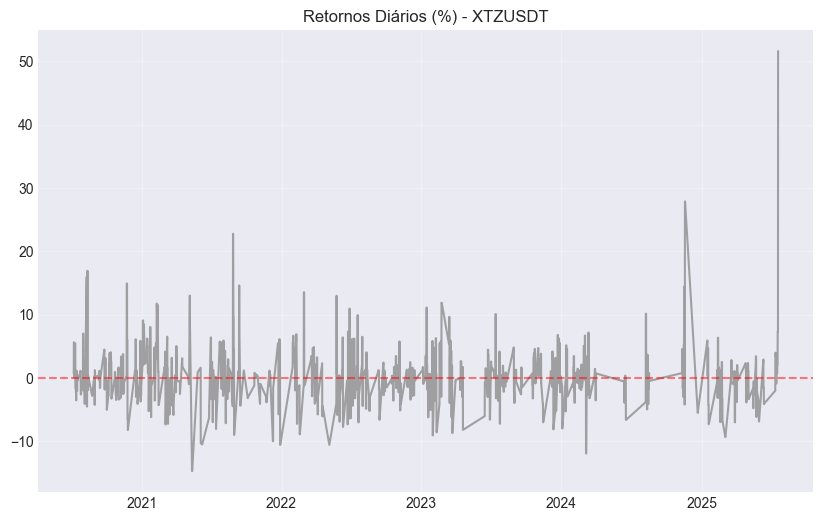

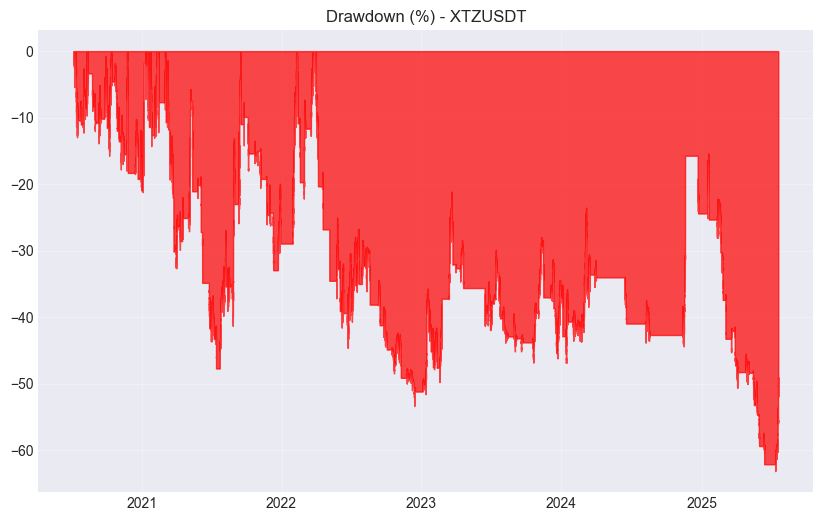

In [346]:
# --- MÉTRICAS ---
# Organização dos Dados
df_metrics = pd.DataFrame(trades, columns=['Timestamp', 'Valor', 'Saldo'])
df_metrics.index = pd.to_datetime(df_metrics['Timestamp'])
df_metrics.drop(columns=['Timestamp'], inplace=True)

# Remoção de index duplicados, erro que estava dando
if df_metrics.index.duplicated().any():
    df_metrics = df_metrics.loc[~df_metrics.index.duplicated(keep='first')]

# Variações
df_metrics['Var_Saldo'] = df_metrics['Saldo'].pct_change()
df_metrics['Var_Valor'] = df_metrics['Valor'].pct_change()

# Sharpe
def sharpe(returns: pd.Series, annual_risk_free_rate: float, periods_per_year: int = 365) -> float:
    if returns.std() == 0:
        return 0.0
    mean_periodic_return = returns.mean()
    std_periodic_return = returns.std()
    annualized_return = mean_periodic_return * periods_per_year
    annualized_volatility = std_periodic_return * np.sqrt(periods_per_year)
    sharpe_ratio = (annualized_return - annual_risk_free_rate) / annualized_volatility
    return sharpe_ratio
sharpe_ratio_estrategia = sharpe(df_metrics['Var_Saldo'].dropna(), 0)
sharpe_ratio_buy_and_hold = sharpe(df_metrics['Var_Valor'].dropna(), 0)

print(f'Sharpe Ratio (Estratégia): {sharpe_ratio_estrategia:.4f}')
print(f'Sharpe Ratio (Buy & Hold): {sharpe_ratio_buy_and_hold:.4f}')

# Drawdown
def drawdown_def(returns: pd.Series) -> float:
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min(), drawdown
dd_estrategia, dd_estrategia_series = drawdown_def(df_metrics['Var_Saldo'].dropna())
dd_buy_and_hold, dd_buy_and_hold_series = drawdown_def(df_metrics['Var_Valor'].dropna())

df_metrics['Drawdown_Estrategia'] = dd_estrategia_series
df_metrics['Drawdown_Buy_and_Hold'] = dd_buy_and_hold_series

print(f'Máximo Drawdown (Estratégia): {dd_estrategia * -100:.2f}%')
print(f'Máximo Drawdown (Buy & Hold): {dd_buy_and_hold * -100:.2f}%')

daily_prod_saldo = (1 + df_metrics['Var_Saldo']).groupby(df_metrics.index.date).transform('prod')
df_metrics['Var_Saldo_Diario'] = daily_prod_saldo - 1

# Gráfico de Retornos Diários
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_metrics.index, df_metrics['Var_Saldo_Diario'] * 100, alpha=0.7, color='gray')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_title('Retornos Diários (%) - ' + SYMBOL)
ax.grid(True, alpha=0.3)
plt.savefig(f'..//..//figures//ml//retornos_{SYMBOL}.png', dpi=300, bbox_inches='tight')

# Gráfico de Drawdown
capital_peak = df_metrics['Saldo'].expanding().max()
drawdown = (df_metrics['Saldo'] - capital_peak) / capital_peak * 100
fig, ax = plt.subplots(figsize=(10,6))
ax.fill_between(df_metrics.index, drawdown, 0, alpha=0.7, color='red')
ax.set_title('Drawdown (%) - ' + SYMBOL)
ax.grid(True, alpha=0.3)
plt.savefig(f'..//..//figures//ml//drawdown_{SYMBOL}.png', dpi=300, bbox_inches='tight')


In [ ]:
# Salva as trades em um arquivo CSV
trades.to_csv(f'..//..//figures//ml//trades_{SYMBOL}.csv', index=False)

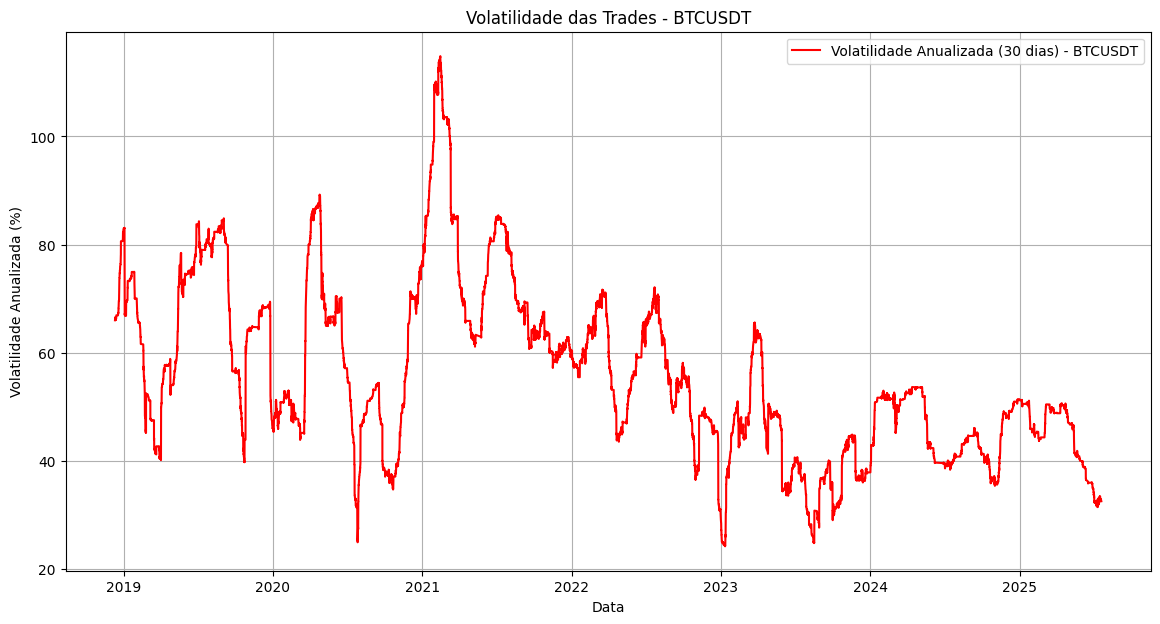

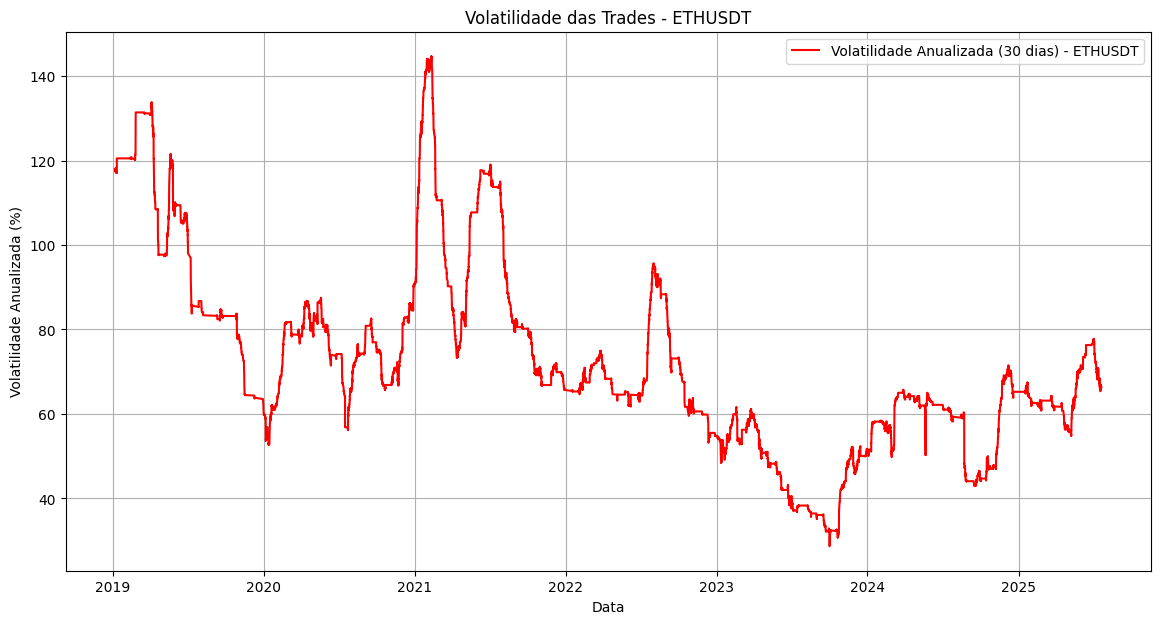

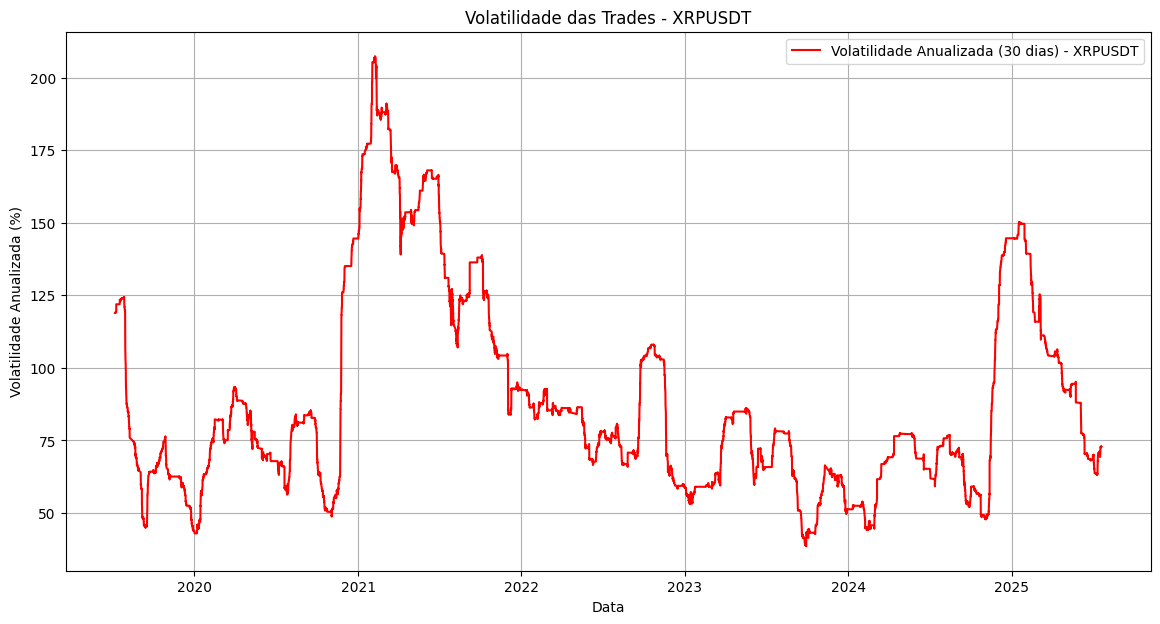

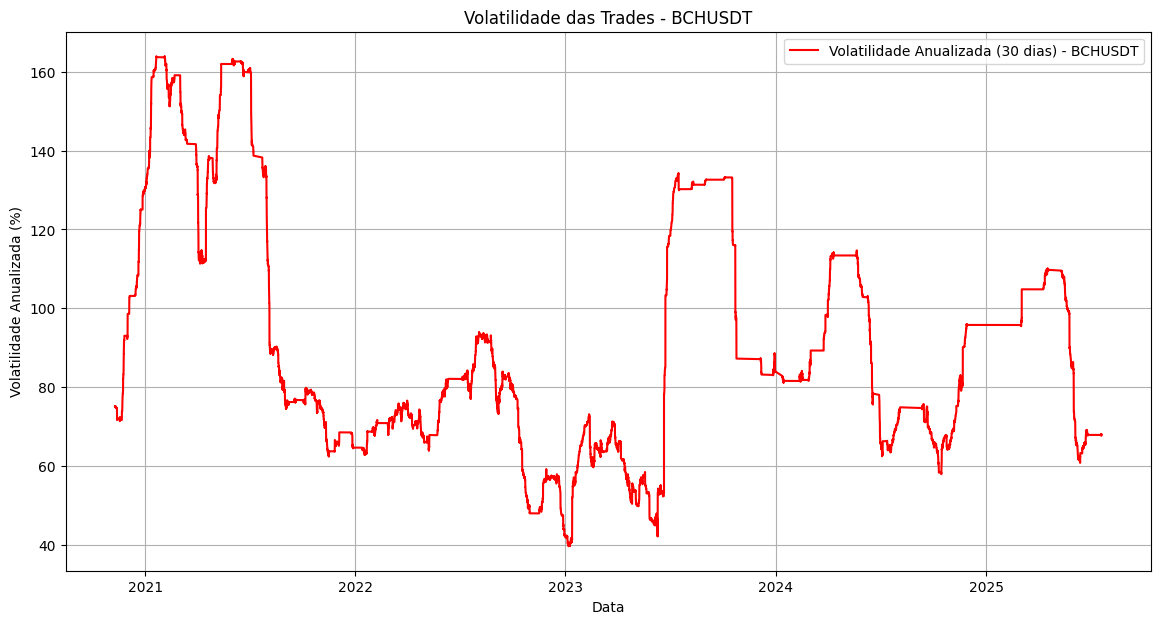

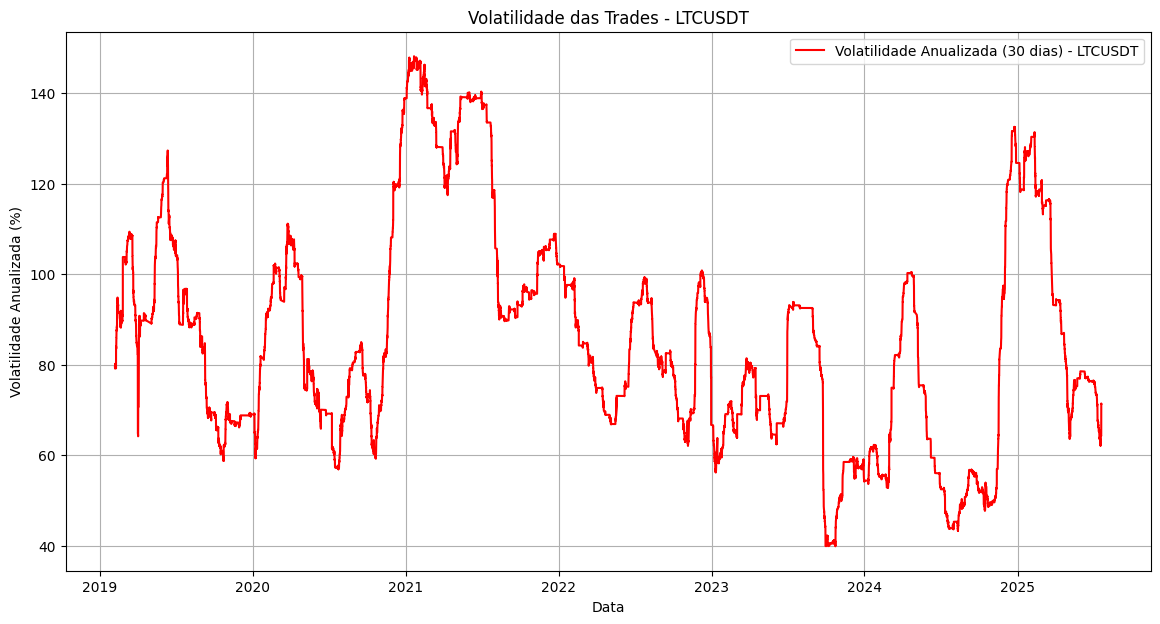

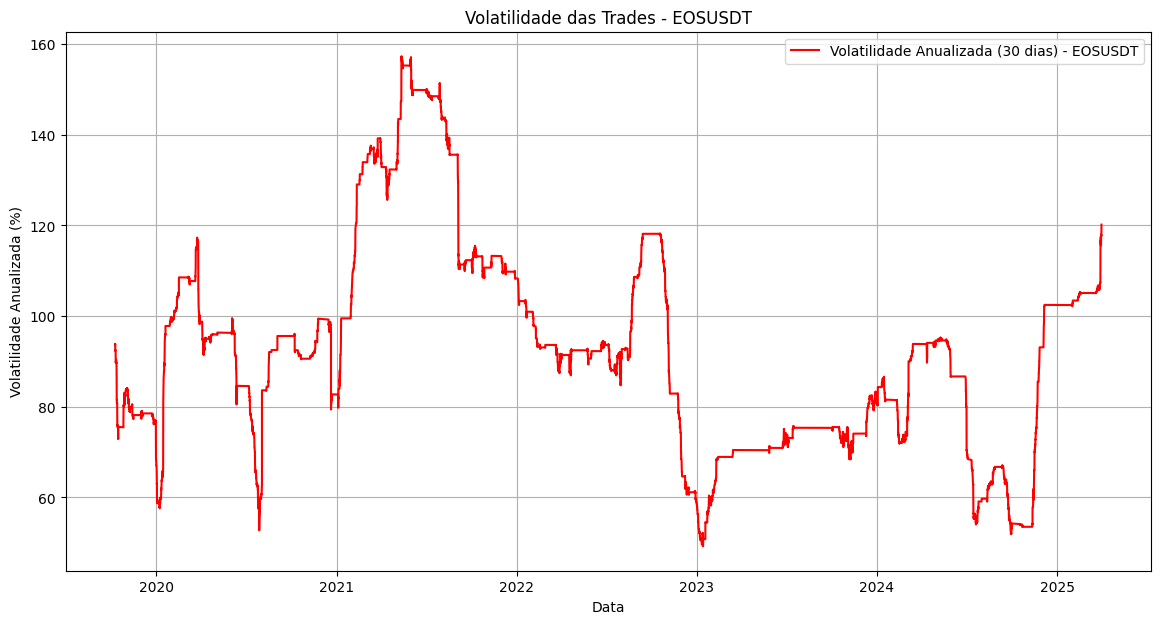

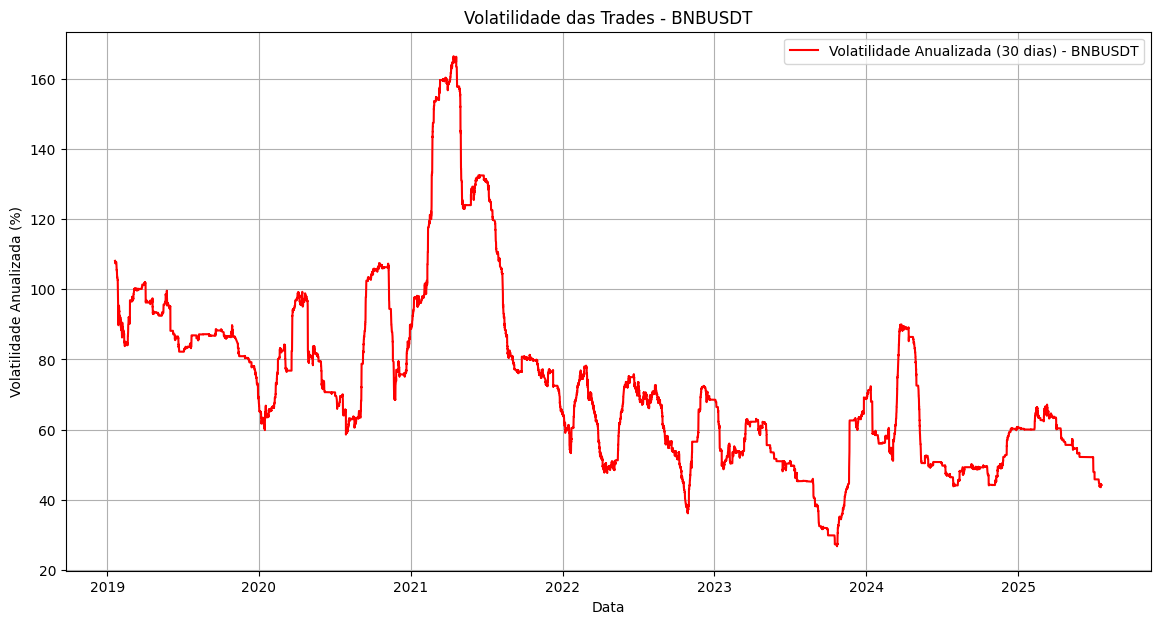

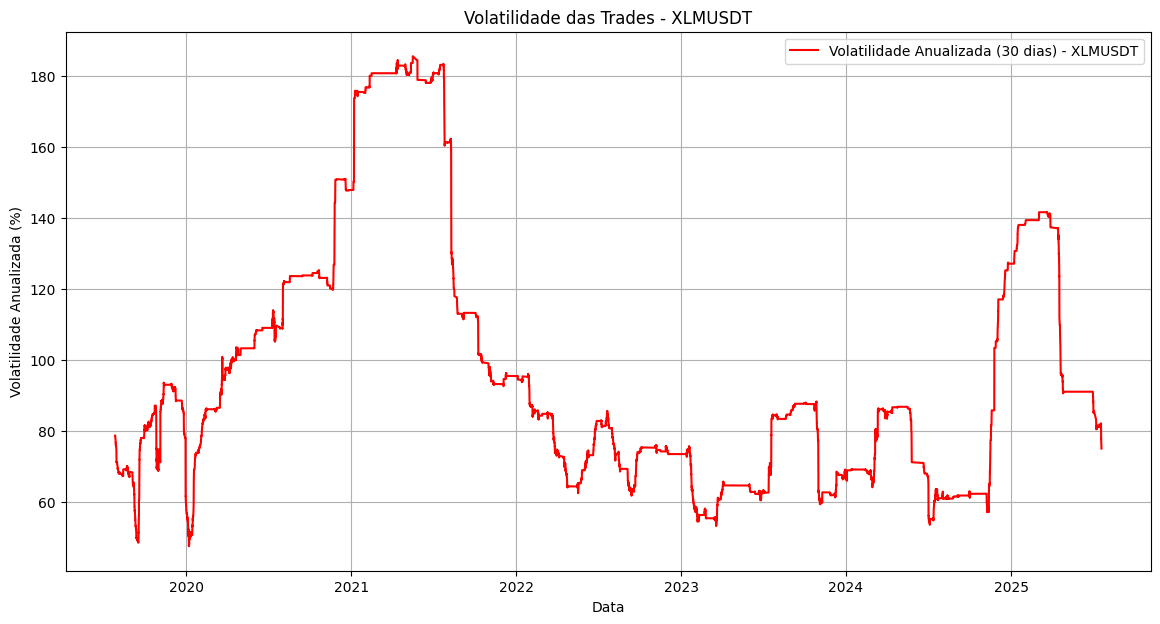

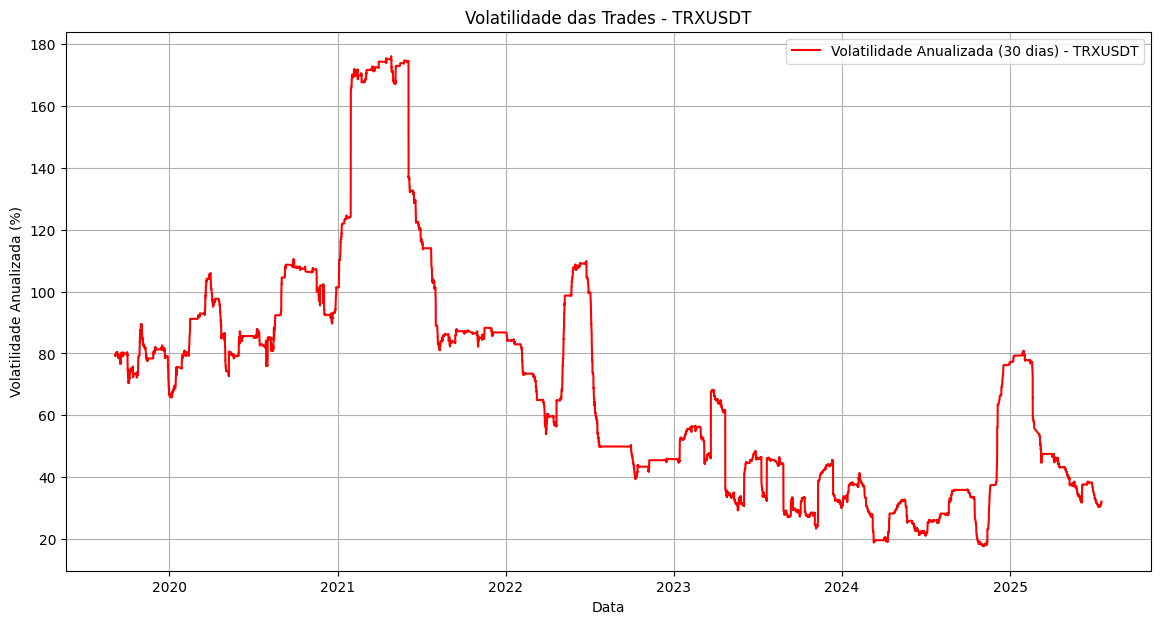

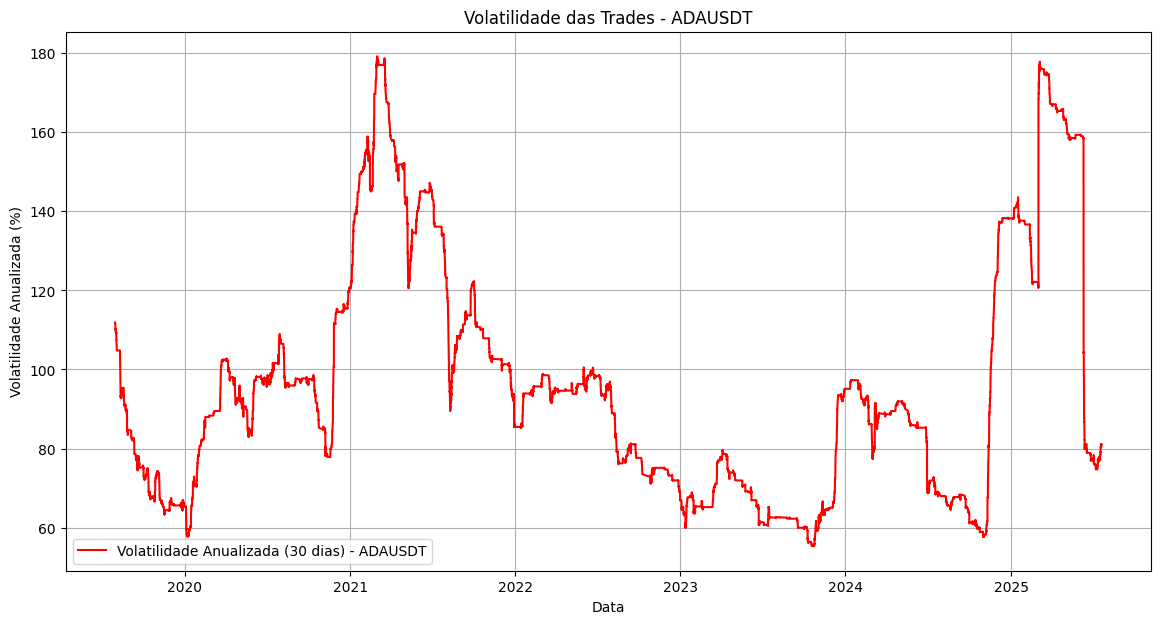

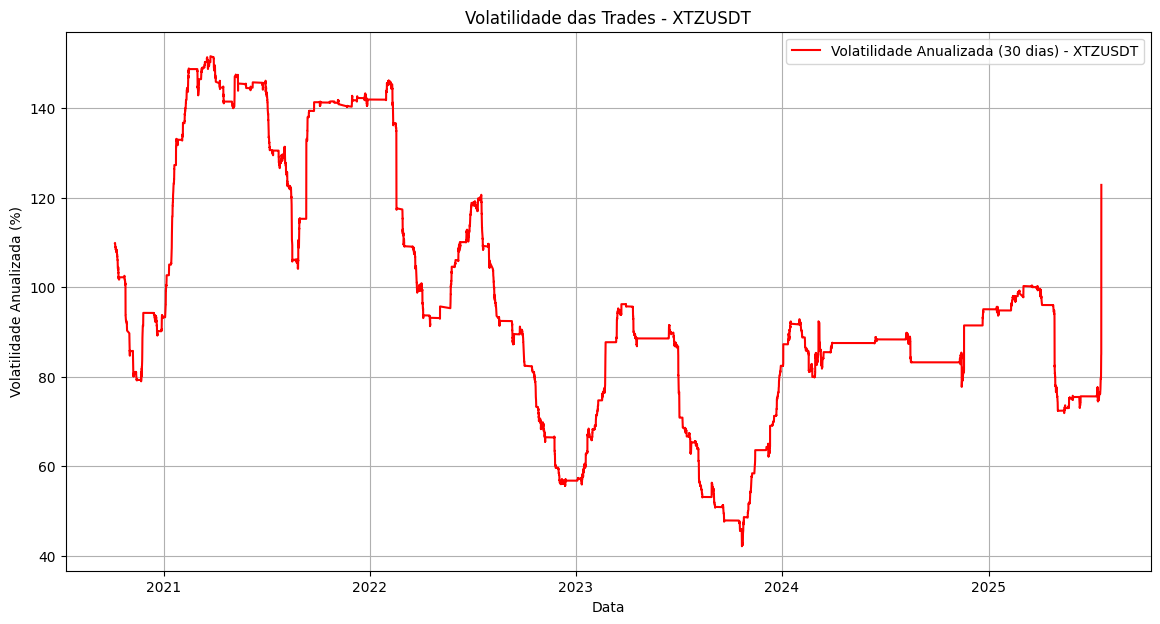

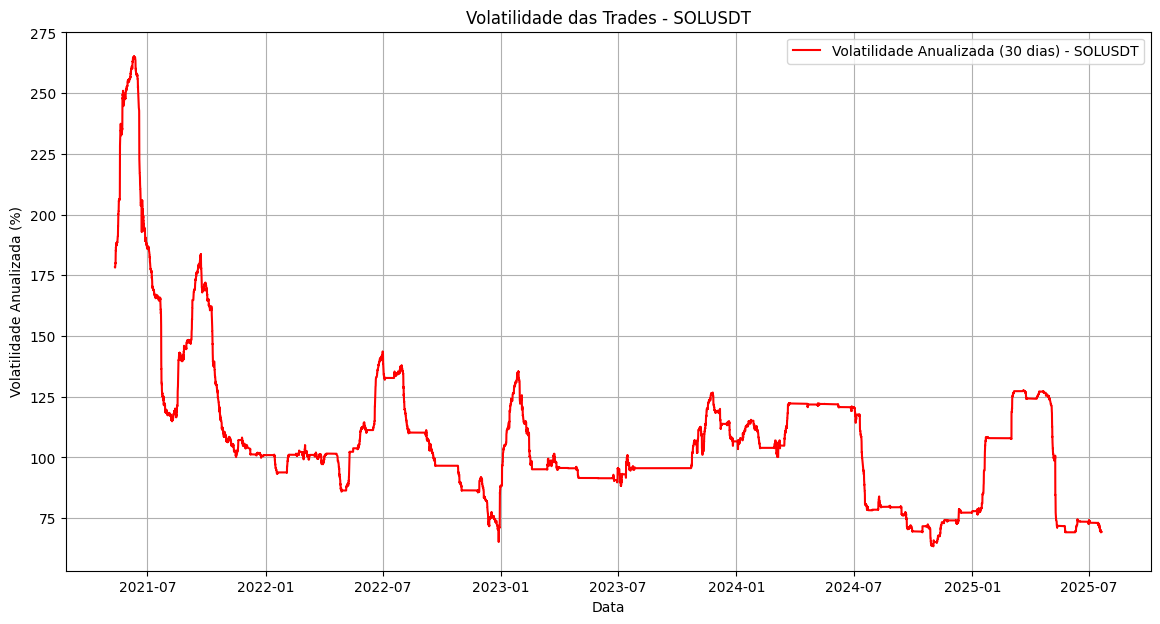

In [ ]:
# Cria um gráfico de volatilidade das trades
symbols = ['BTCUSDT','ETHUSDT','XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT', 'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'SOLUSDT']

# Parâmetros para o cálculo da volatilidade anualizada
days_in_year = 365
hours_in_day = 24
annualization_factor = (days_in_year * hours_in_day)**0.5

# Janela de 30 dias em horas para o rolling
window_30_days = 30 * hours_in_day

# Condição para executar a geração de gráficos
conf = False

if conf:
    for symbol in symbols:
        trades = pd.read_csv(f'../../figures/ml/trades_{symbol}.csv')
        
        # Converte a coluna 'Timestamp' para datetime e a define como índice
        trades['Timestamp'] = pd.to_datetime(trades['Timestamp'])
        trades.set_index('Timestamp', inplace=True)
        
        # Calcule os retornos percentuais do saldo normalizado
        # Isso transforma o saldo em uma série de retornos, que é o que precisamos para a volatilidade
        trades['retornos_percentuais'] = trades['Saldo_norm'].pct_change()
        
        # Calcule o desvio padrão dos retornos em uma janela de 30 dias (720h)
        # e depois anuaize, multiplicando pelo fator de anualização
        trades['volatilidade_anualizada_percentual'] = trades['retornos_percentuais'].rolling(window=window_30_days).std() * annualization_factor * 100

        # Cria o gráfico
        plt.figure(figsize=(14, 7))
        
        # Plota a volatilidade anualizada em percentual
        plt.plot(trades.index, trades['volatilidade_anualizada_percentual'], label=f'Volatilidade Anualizada (30 dias) - {symbol}', color='red')
        
        plt.title(f'Volatilidade das Trades - {symbol}')
        plt.xlabel('Data')
        plt.ylabel('Volatilidade Anualizada (%)')
        plt.legend()
        plt.grid(True)
        
        # Salva a imagem
        plt.savefig(f'../../figures/ml/volatilidade_anualizada_trades_{symbol}.png', dpi=300, bbox_inches='tight')
        
        # Exibe o gráfico e fecha a figura
        plt.show()
        plt.close() 